### PRE-ENTREGA 4


Integrantes: Andrea Rodriguez - Belen Massuco

Fecha de entrega: 10 de julio 2025

**INTRODUCCIÓN**

Para nuestro proyecto final, seleccionamos un dataset de estadísticas agrícolas históricas de Argentina, proveniente del portal oficial del Ministerio de Agricultura. Este dataset incluye registros desde el ciclo agrícola 1969/1970 hasta 2022/2023, con información organizada por provincia y departamento. Las variables principales son:

- provincia_nombre: Nombre de la provincia
- departamento_nombre: Nombre del departamento
- cultivo: Nombre del cultivo
- ciclo: Año de la campaña
- sup_sembrada: Cantidad de superficie semabrada en hectareas
- sup_cosechada: Cantidad de superficie cosechada en hectareas
- produccion: Cantidad de produccion en toneladas
- rendimiento: Cantidad de rendimiento en kilos por hectarea

Fuente dataset: https://datos.magyp.gob.ar/dataset/estimaciones-agricolas

  ---

**ALCANCE**


En esta fase del proyecto se realizaron las siguientes tareas:

 * Análisis exploratorio de los datos.

 * Desarrollo de un modelo de aprendizaje no supervisado (clustering).

 * Aplicación del algoritmo de clustering.

 * Justificación de las decisiones metodológicas adoptadas.

 ---


**OBJETIVO**

Agrupar registros de cultivos en función de sus características de producción (superficie sembrada, producción total, rendimiento) para:

Identificar tipos de producción (por ejemplo: baja escala, intensiva, extensiva)



### Cargamos librerias para exploración y preprocesamiento de datos


In [ ]:
# Análisis y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Cargamos y exploramos dataset

Se trabaja con mismo dataset de la pre-entrega 3

In [ ]:
# Importar dataset
df = pd.read_csv('estimaciones_agricolas.csv', encoding='latin1', delimiter=',', dtype={9: object, 10: object, 11: object})

In [ ]:
# Mostrar primeras observaciones
df.head()

,provincia_id,provincia_nombre,departamento_id,departamento_nombre,id_cultivo,cultivo,id_ciclo,ciclo,sup_sembrada,sup_cosechada,produccion,rendimiento
0,6,Buenos Aires,854,25 de Mayo,1.0,Ajo,1,1969/1970,3,3,10,3333
1,6,Buenos Aires,14,Adolfo Gonzales Chaves,1.0,Ajo,1,1969/1970,15,15,82,5467
2,6,Buenos Aires,21,Alberti,1.0,Ajo,1,1969/1970,5,5,7,1400
3,6,Buenos Aires,28,Almirante Brown,1.0,Ajo,1,1969/1970,2,2,8,4000
4,6,Buenos Aires,77,Arrecifes,1.0,Ajo,1,1969/1970,6,6,15,2500


In [ ]:
# Mostrar cantidad de registros/observaciones y features
ff = df.shape
print(f'El dataset contiene {ff[0]} observaciones y {ff[1]} features.')

El dataset contiene 153889 observaciones y 12 features.


In [ ]:
# Ver tipos de datos
df.dtypes

,0
provincia_id,int64
provincia_nombre,object
departamento_id,int64
departamento_nombre,object
id_cultivo,float64
cultivo,object
id_ciclo,int64
ciclo,object
sup_sembrada,int64
sup_cosechada,object


In [ ]:
# Nombre de features
df.columns

Index(['provincia_id', 'provincia_nombre', 'departamento_id',
       'departamento_nombre', 'id_cultivo', 'cultivo', 'id_ciclo', 'ciclo',
       'sup_sembrada', 'sup_cosechada', 'produccion', 'rendimiento'],
      dtype='object')

In [ ]:
# Renombrar features - agregar unidades
df.rename(columns={'sup_sembrada': 'sup_sembrada_ha', 'sup_cosechada': 'sup_cosechada_ha', 'produccion': 'produccion_ton', 'rendimiento':'rendimiento_kg/ha'}, inplace=True)

In [ ]:
# Se convierten las columnas sup_cosechada_ha', 'produccion_ton' y 'rendimiento_kg/ha' de object a float/int
columns_to_convert = ['sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha']

# Limpiar y convertir a float/int
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)  # eliminar separadores de miles
    df[col] = df[col].str.replace(',', '.', regex=False)             # cambiar coma decimal por punto
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Verificar resultado
print(df[columns_to_convert].dtypes)

sup_cosechada_ha     float64
produccion_ton       float64
rendimiento_kg/ha    float64
dtype: object


### Creación y selección de features

**Región**

In [ ]:
# Diccionario de provincias agrupadas por región
region_map = {
    'Santiago del Estero': 'NOA',
    'Tucuman': 'NOA',
    'Catamarca': 'NOA',
    'Jujuy': 'NOA',
    'Salta': 'NOA',
    'La Rioja': 'NOA',

    'Chaco': 'NEA',
    'Corrientes': 'NEA',
    'Formosa': 'NEA',
    'Misiones': 'NEA',

    'Buenos Aires': 'Pampeana',
    'Santa Fe': 'Pampeana',
    'Cordoba': 'Pampeana',
    'Entre Rios': 'Pampeana',
    'La Pampa': 'Pampeana',


    'Mendoza': 'Cuyo',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',

    'Neuquen': 'Patagonia',
    'Rio Negro': 'Patagonia',
    'Chubut': 'Patagonia',
    'Santa Cruz': 'Patagonia',
    'Tierra del Fuego': 'Patagonia'
}

In [ ]:
df['region'] = df['provincia_nombre'].map(region_map)

**Tasa de cosecha**

In [ ]:
df['tasa_cosecha'] = df['sup_cosechada_ha'] / df['sup_sembrada_ha']

**Año**

In [ ]:
df['anio'] = df['ciclo'].str[:4].astype(int)

*Se eliminan columnas*.

- provincia_nombre: se elimina porque se decide trabajar por regiones dónde éstas ya son representadas.
- provincia_id: se elimina porque ya no aporta valor.
- departamento_id: no sera útil en este análisis
- departamento_nombre: no sera útil en este análisis
- id_ciclo: no será útil en este análisis
- ciclo: la reemplaza la feature anio
- id_cultivo: no será útil en este análisis

*Para el análisis se usaran*:

- 'region'
- 'cultivo'
- 'sup_sembrada_ha'
- 'sup_cosechada_ha'
- 'produccion_ton'
- 'rendimiento_kg/ha'
- 'tasa_cosecha'
- 'anio'

In [ ]:
df.drop(columns=['provincia_id', 'provincia_nombre', 'departamento_id', 'departamento_nombre',
                 'id_ciclo', 'ciclo', 'id_cultivo'], inplace=True)

In [ ]:
df.head()

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
0,Ajo,3,3.0,10.0,3333.0,Pampeana,1.0,1969
1,Ajo,15,15.0,82.0,5467.0,Pampeana,1.0,1969
2,Ajo,5,5.0,7.0,1400.0,Pampeana,1.0,1969
3,Ajo,2,2.0,8.0,4000.0,Pampeana,1.0,1969
4,Ajo,6,6.0,15.0,2500.0,Pampeana,1.0,1969


### Estadística descriptiva de variables numéricas

Analizamos las principales variables cuantitativas del dataset: superficie sembrada y cosechada (en hectáreas), producción total (en toneladas), rendimiento (en kg/ha) y tasa de cosecha (cosechada / sembrada).

In [ ]:
print(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']].describe())

       sup_sembrada_ha  sup_cosechada_ha  produccion_ton  rendimiento_kg/ha  \
count     1.538890e+05      1.538760e+05    1.538750e+05      153875.000000   
mean      1.228560e+04      1.075362e+04    3.331973e+04        3489.310772   
std       3.585014e+04      3.436686e+04    1.276209e+05        5577.586344   
min       0.000000e+00      0.000000e+00    0.000000e+00           0.000000   
25%       1.800000e+02      6.100000e+01    1.800000e+02        1000.000000   
50%       1.439000e+03      8.000000e+02    1.790000e+03        1919.000000   
75%       8.500000e+03      6.000000e+03    1.400000e+04        3501.000000   
max       1.096100e+06      1.066100e+06    8.620000e+06      300000.000000   

       tasa_cosecha  
count  1.506520e+05  
mean            inf  
std             NaN  
min    0.000000e+00  
25%    6.551724e-01  
50%    9.636364e-01  
75%    1.000000e+00  
max             inf  


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


El mínimo para las variables analizadas resultó cero.


In [ ]:
# Contar valores igual a cero
(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']] == 0).sum()


,0
sup_sembrada_ha,3225
sup_cosechada_ha,16314
produccion_ton,13147
rendimiento_kg/ha,16348
tasa_cosecha,13090


Chequeo de valores nulos en la feature "sup_sembrada_ha" ya que el mínimo estadístico es cero

In [ ]:
df['sup_sembrada_ha'].sort_values().head(3)

,sup_sembrada_ha
3338,0
3339,0
3340,0


Aunque el resumen estadístico muestra un valor mínimo de 0 en la superficie sembrada, al inspeccionar los registros más bajos se comprobó que no existen valores nulos reales. Los valores mínimos observados son de 1 o 2 hectáreas, lo que puede corresponder a registros de pequeña escala. Por lo tanto, se concluye que la superficie sembrada siempre fue mayor que cero en los datos analizados.

Mostrar filas con datos con valor cero

In [ ]:
df[(df['sup_cosechada_ha'] == 0) |
   (df['produccion_ton'] == 0) |
   (df['rendimiento_kg/ha'] == 0) |
   (df['tasa_cosecha'] == 0)]

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
307,Algodón,6,0.0,0.0,0.0,NOA,0.0,1969
410,Alpiste,100,0.0,0.0,0.0,Pampeana,0.0,1969
496,Avena,2500,0.0,0.0,0.0,Pampeana,0.0,1969
498,Avena,100,0.0,0.0,0.0,Pampeana,0.0,1969
501,Avena,3000,0.0,0.0,0.0,Pampeana,0.0,1969
...,...,...,...,...,...,...,...,...
153492,Sorgo,1000,0.0,0.0,0.0,Pampeana,0.0,2022
153567,Sorgo,450,0.0,0.0,0.0,NOA,0.0,2022
153754,Trigo total,0,0.0,0.0,0.0,NEA,NaN,2022
153796,Trigo total,0,0.0,0.0,0.0,NOA,NaN,2022


Durante el análisis exploratorio, se identificaron registros en los que la superficie sembrada es distinta de cero, pero no se registra superficie cosechada. Estos casos pueden deberse a pérdidas totales por eventos climáticos, abandono del cultivo, decisiones económicas o errores en la carga de datos.

Dado que representan situaciones reales del proceso agrícola, se decidió conservarlos en esta etapa con el objetivo de evaluar su impacto potencial en el modelo de machine learning que se desarrollará posteriormente. Su inclusión permitirá analizar si estas situaciones extremas contienen información útil para la predicción o si, por el contrario, generan ruido que justifique su exclusión futura.

In [ ]:
cols = ['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']
# Crear el filtro
filtro_todas_nan_o_cero = (df[cols].isna() | (df[cols] == 0)).all(axis=1)

# Contar cuántas filas se van a eliminar
print("Filas a eliminar:", filtro_todas_nan_o_cero.sum())

Filas a eliminar: 23


### Análisis exploratorio para clustering

En esta sección realizamos un análisis exploratorio específico para preparar los datos que serán utilizados en el modelo de aprendizaje no supervisado. Se analizarán las variables numéricas clave, se evaluarán valores faltantes, distribución, outliers y relaciones entre variables.


In [ ]:
df.head()

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
0,Ajo,3,3.0,10.0,3333.0,Pampeana,1.0,1969
1,Ajo,15,15.0,82.0,5467.0,Pampeana,1.0,1969
2,Ajo,5,5.0,7.0,1400.0,Pampeana,1.0,1969
3,Ajo,2,2.0,8.0,4000.0,Pampeana,1.0,1969
4,Ajo,6,6.0,15.0,2500.0,Pampeana,1.0,1969


In [ ]:
# Eliminamos filas con valores faltantes solo en las variables clave
df_cluster = df.dropna(subset=['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha']).copy()

print(f"Dimensión del dataset después de eliminar nulos: {df_cluster.shape}")

Dimensión del dataset después de eliminar nulos: (153875, 8)


In [ ]:
# Contar observaciones por cultivo por produccion
conteo = df.groupby('cultivo').agg(
    cantidad=('produccion_ton', 'count'),
    suma_produccion=('produccion_ton', 'sum')
).reset_index()


# Calcular porcentaje
total = conteo['cantidad'].sum()
conteo['porcentaje'] = (conteo['cantidad'] / total * 100).round(2)

conteo_ordenado = conteo.sort_values(by='cantidad', ascending=False)

# Mostrar resultados
print(conteo_ordenado.head(5))

        cultivo  cantidad  suma_produccion  porcentaje
23         Maíz     17113     1.039261e+09       11.12
38  Trigo total     12770     6.373855e+08        8.30
36        Sorgo     11622     1.955219e+08        7.55
35   Soja total     11391     1.224195e+09        7.40
5         Avena     11117     2.605297e+07        7.22


In [ ]:
# Contar cantidad de registros por región
conteo_por_region = df['region'].value_counts().reset_index()
conteo_por_region.columns = ['region', 'cantidad']

# Ordenar de mayor a menor
conteo_por_region = conteo_por_region.sort_values(by='cantidad', ascending=False)

# Mostrar resultado
print(conteo_por_region)

      region  cantidad
0   Pampeana     90288
1        NEA     27722
2        NOA     24469
3       Cuyo      7955
4  Patagonia      3455


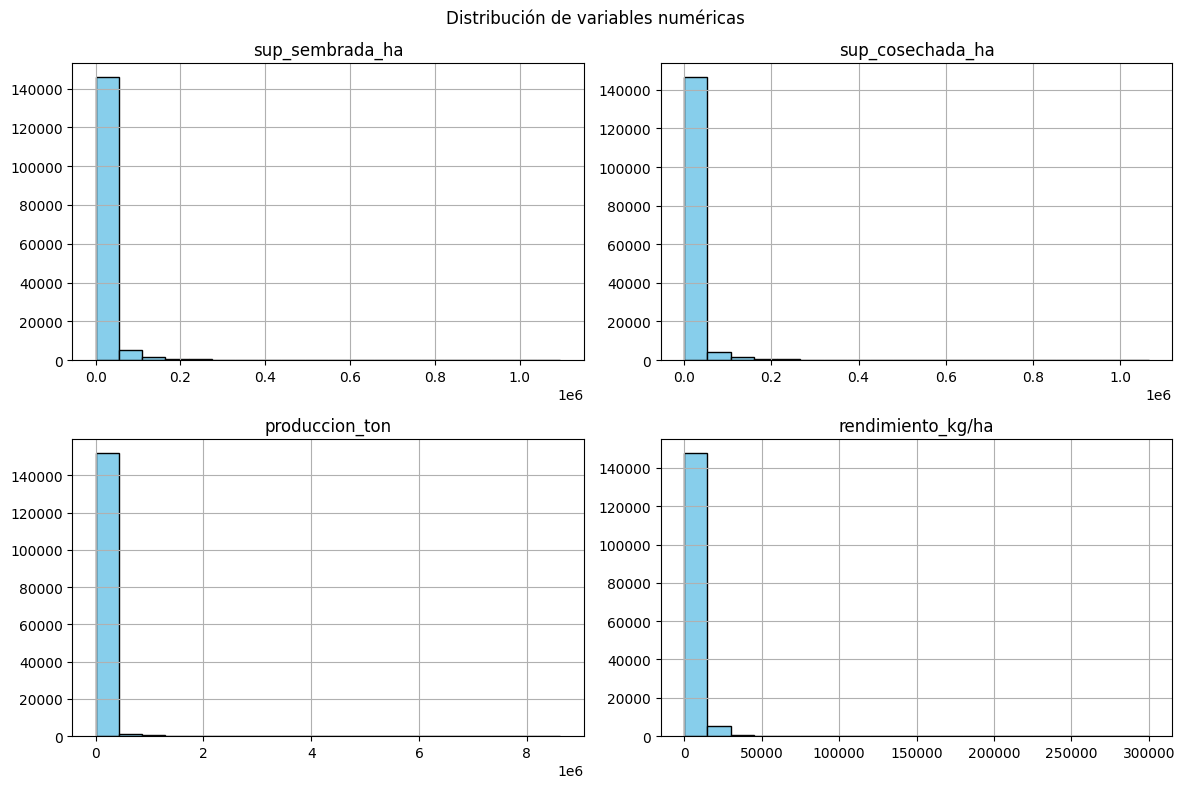

In [ ]:
# Visualización de la distribución de variables numéricas
numeric_vars = ['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha']

df[numeric_vars].hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas")
plt.tight_layout()
plt.show()

Todas las variables (sup_sembrada_ha, sup_cosechada_ha, produccion_ton, rendimiento_kg/ha) tienen distribución fuertemente sesgada a la derecha (right-skewed).



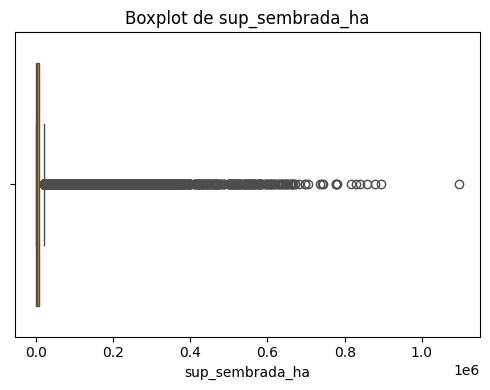

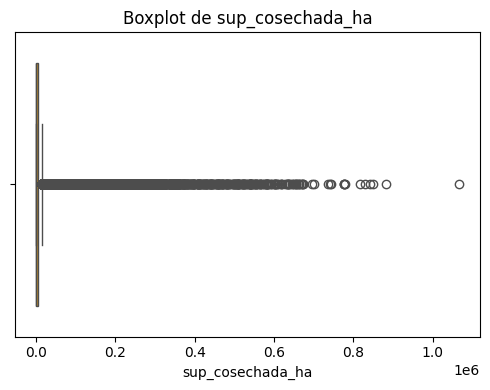

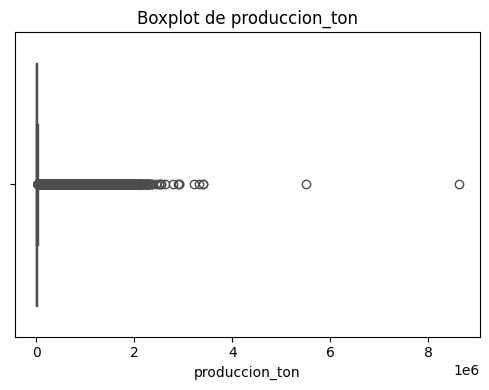

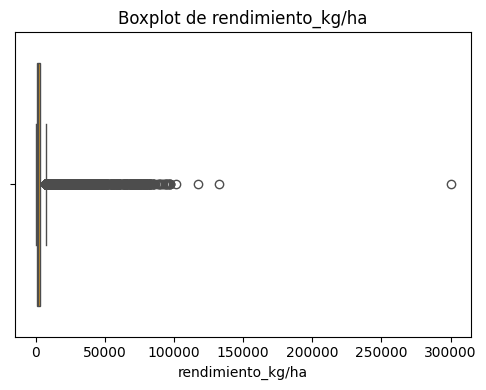

In [ ]:
# Boxplots para detectar posibles valores atípicos
for var in numeric_vars:
    plt.figure(figsize=(5, 4))
    sns.boxplot(x=df[var], color='orange')
    plt.title(f"Boxplot de {var}")
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

Las 4 variables tienen muchos outliers, especialmente en el extremo derecho (valores muy altos).

Esto es esperable en datos agrícolas: algunos departamentos o campañas son excepcionalmente grandes en superficie o producción.

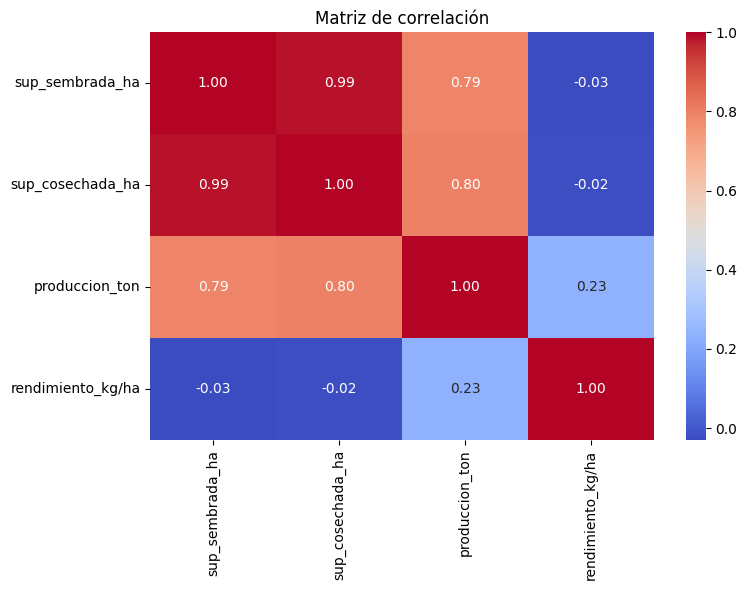

In [ ]:
# Matriz de correlación entre variables numéricas
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_vars].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

sup_sembrada_ha y sup_cosechada_ha están muy fuertemente correlacionadas (0.99): indican casi lo mismo.

También tienen correlación alta con produccion_ton (~0.8).

rendimiento_kg/ha tiene muy poca correlación con las demás variables, lo que significa que aporta información distinta,

Vamos a eliminar sup_cosechada_ha y seguir con las 3 variables clave:

- sup_sembrada_ha

- produccion_ton

- rendimiento_kg/ha

Estas aportan buena información y menor redundancia.

### Preparación de los datos para clustering

En esta sección seleccionamos las variables numéricas relevantes, escalamos los datos para evitar sesgos por magnitudes diferentes, y preparamos un conjunto limpio para aplicar modelos de agrupamiento.


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

In [ ]:
# Se categoriza la columna región
df_cluster['region_encoder'] = le.fit_transform(df_cluster['region'])

In [ ]:
df_cluster.head()

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio,region_encoder
0,Ajo,3,3.0,10.0,3333.0,Pampeana,1.0,1969,3
1,Ajo,15,15.0,82.0,5467.0,Pampeana,1.0,1969,3
2,Ajo,5,5.0,7.0,1400.0,Pampeana,1.0,1969,3
3,Ajo,2,2.0,8.0,4000.0,Pampeana,1.0,1969,3
4,Ajo,6,6.0,15.0,2500.0,Pampeana,1.0,1969,3


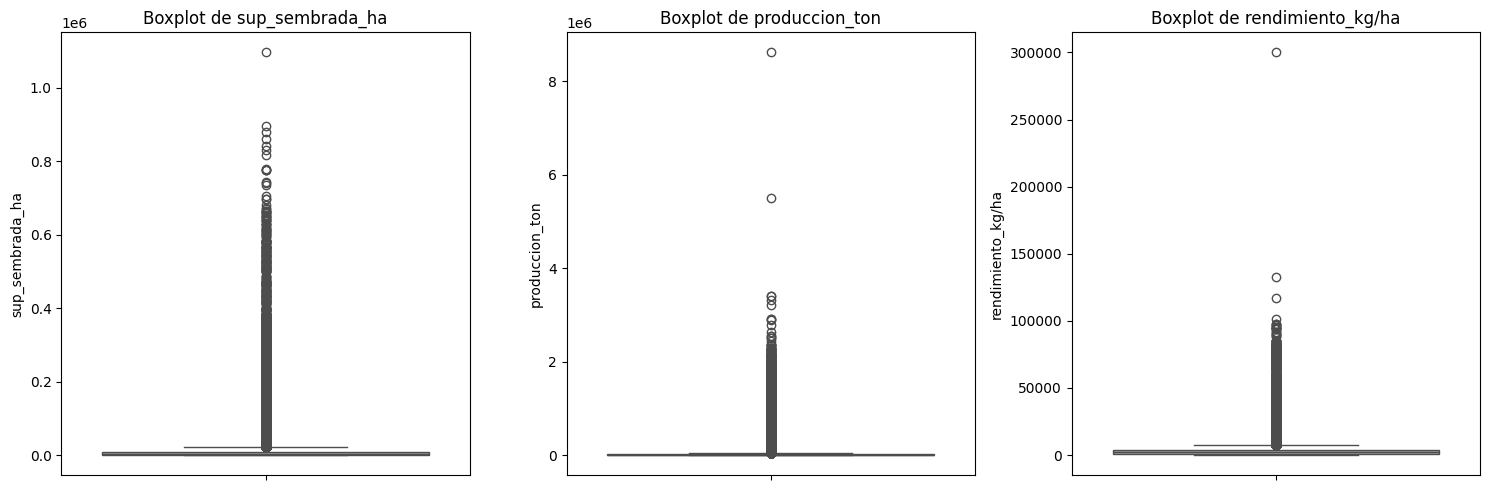

In [ ]:
numeric_cols=['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha']

# Cantidad de variables
n = len(numeric_cols)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

for i, var in enumerate(numeric_cols):
    sns.boxplot(y=df[var], color='orange', ax=axes[i])
    axes[i].set_title(f"Boxplot de {var}")
    axes[i].set_ylabel(var)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Definimos las variables finales para clustering
features = ['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha']

# Seleccionamos solo esas columnas y eliminamos filas con nulos
df_cluster = df_cluster[features].dropna().copy()

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Guardamos en un DataFrame para facilitar análisis posterior
df_scaled = pd.DataFrame(X_scaled, columns=features)

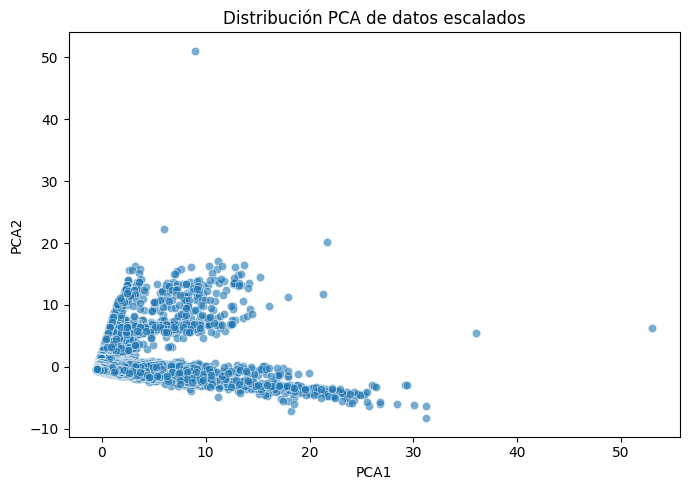

In [ ]:
# Reducción de dimensionalidad para visualizar en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Guardamos en el DataFrame
df_scaled['PCA1'] = X_pca[:, 0]
df_scaled['PCA2'] = X_pca[:, 1]

# Visualización simple
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', data=df_scaled, alpha=0.6)
plt.title("Distribución PCA de datos escalados")
plt.tight_layout()
plt.show()

In [ ]:
# Mostrar las cargas (loadings) de cada variable en los componentes
features = ['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha'] # Updated features list
cargas = pd.DataFrame(
    pca.components_,
    columns=features,
    index=['PC1', 'PC2']
).T

print(cargas)

                        PC1       PC2
sup_sembrada_ha    0.681424 -0.280756
produccion_ton     0.710231  0.030670
rendimiento_kg/ha  0.176726  0.959289


PC1:
Es una combinación principalmente de producción y superficie sembrada. Probablemente representa el tamaño total del cultivo.

PC2:
Está casi totalmente dominado por el rendimiento. Probablemente representa la eficiencia o productividad por unidad de superficie.



In [ ]:
# Varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_

for i, var in enumerate(explained_var):
    print(f"PC{i+1} explica el {var*100:.2f}% de la varianza")


PC1 explica el 60.56% de la varianza
PC2 explica el 33.87% de la varianza


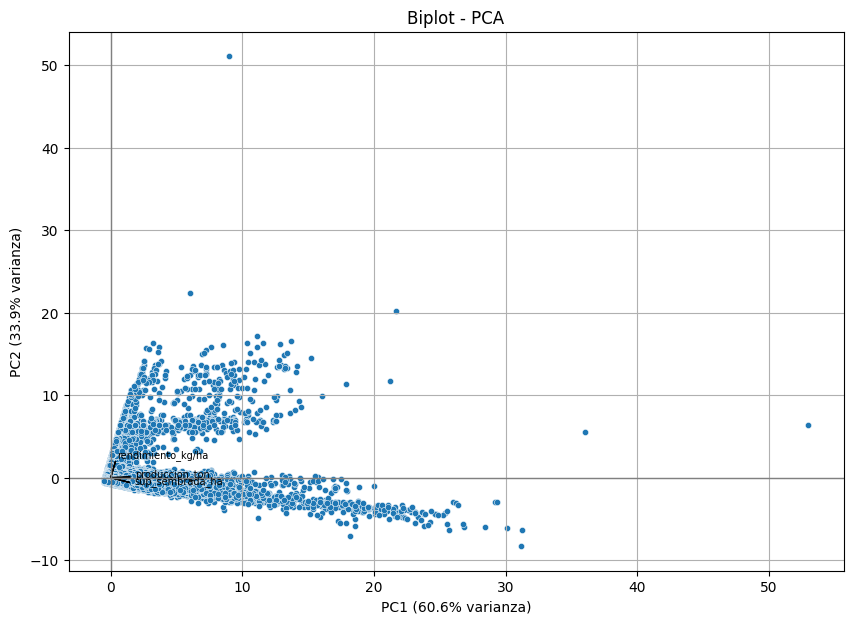

In [ ]:
# Crear biplot
plt.figure(figsize=(10, 7))

# 1. Puntos (datos proyectados)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=20)

# 2. Flechas (cargas de las variables originales)
for i, var in enumerate(['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha']):
    plt.arrow(0, 0,
              pca.components_[0, i]*2,  # escalar para que se vean bien
              pca.components_[1, i]*2,
              color='black', head_width=0.05)
    plt.text(pca.components_[0, i]*2.6, pca.components_[1, i]*2.6, var, color='black', fontsize=7)

# Etiquetas y ejes
plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}% varianza)')
plt.title('Biplot - PCA')
plt.grid(True)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.show()

## Aplicación del algoritmo de clustering (K-Means)

En esta sección aplicamos el algoritmo K-Means para agrupar los datos según similitudes en superficie sembrada, superficie cosechada, producción y rendimiento. Para determinar la cantidad óptima de clusters, utilizamos el método del codo y el coeficiente de silueta.


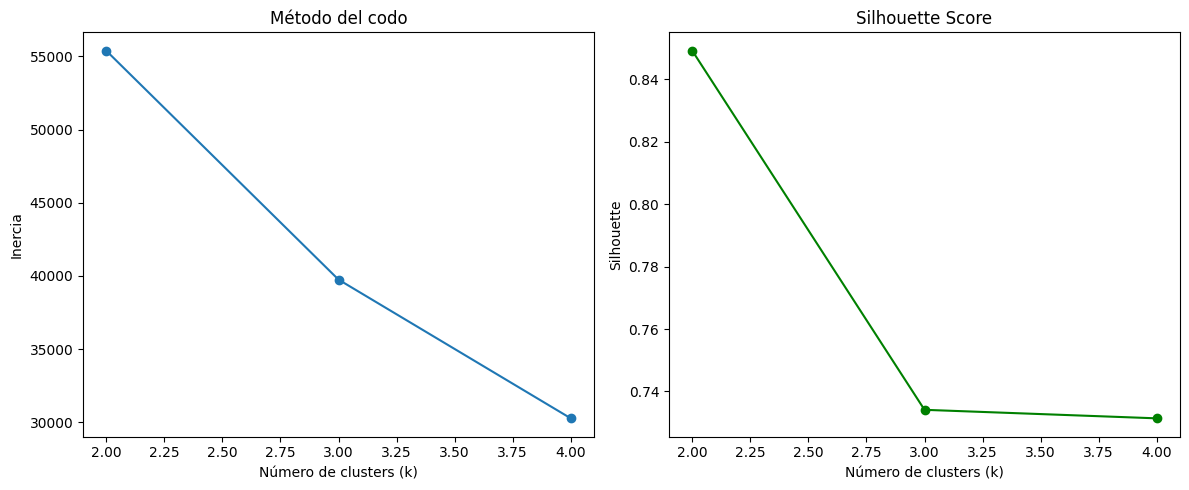

In [ ]:
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Muestreo del 20%
X_sample = resample(X_scaled, n_samples=int(0.2 * len(X_scaled)), random_state=42)

inertia = []
silhouette = []
K_range = range(2, 5)  # más chico

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_sample, kmeans.labels_))

# Gráficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Entrenamos el modelo KMeans con k=3
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(X_scaled)

# Vemos distribución de clusters
df_scaled['cluster'].value_counts().sort_index()

,count
cluster,
0,140998
1,3108
2,9769


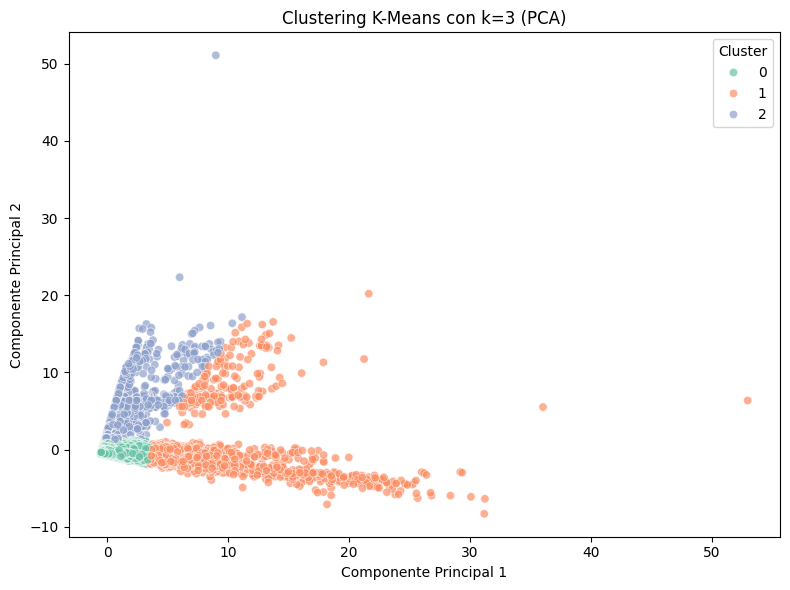

In [ ]:
# Visualización de los clusters en espacio PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='cluster', palette='Set2',
    data=df_scaled, alpha=0.7
)
plt.title(f"Clustering K-Means con k={k_opt} (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

Este grafico se podría interprestar como:

Cluster 0 (verde claro):
Baja superficie sembrada, baja producción, y rendimiento no muy alto

🟢 Pequeños productores o regiones con baja escala y eficiencia promedio o baja

Cluster 1 (naranja):
Alta superficie sembrada y producción, pero rendimiento relativamente bajo

🟠 Productores grandes en escala, pero no necesariamente eficientes. Posiblemente cultivos extensivos con baja productividad por hectárea (ej: soja)

Cluster 2 (azul):
Rendimiento alto, pero no necesariamente gran escala

🔵 Productores o regiones con alta eficiencia (rendimiento por ha), pero de tamaño medio o bajo. Cultivos intensivos o zonas tecnificadas

In [ ]:
# Promedio de variables por cluster
df_cluster['cluster'] = df_scaled['cluster'].values
df_cluster.groupby('cluster')[features].mean()


,sup_sembrada_ha,produccion_ton,rendimiento_kg/ha
cluster,,,
0,9041.436162,19463.425460,2331.117491
1,195232.135457,688798.760940,6678.277992
2,921.547651,24770.487972,19191.186713


##Análisis por cluster
1. Estadísticas descriptivas por cluster.

2. Distribución de cultivos por cluster.

3. Distribución de regiones por cluster.

In [ ]:
# Creamos un DataFrame con las componentes principales
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_cluster.index)

# Aplicamos KMeans con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_pca['cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# Unimos los clusters con el DataFrame original (manteniendo los índices)
df_combined = df.loc[df_cluster.index].copy()
df_combined[['PC1', 'PC2', 'cluster']] = df_pca[['PC1', 'PC2', 'cluster']]

# Mostramos el resultado combinado
df_combined.head()

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio,PC1,PC2,cluster
0,Ajo,3,3.0,10.0,3333.0,Pampeana,1.0,1969,-0.423801,0.061305,0
1,Ajo,15,15.0,82.0,5467.0,Pampeana,1.0,1969,-0.355556,0.428256,0
2,Ajo,5,5.0,7.0,1400.0,Pampeana,1.0,1969,-0.485027,-0.271169,0
3,Ajo,2,2.0,8.0,4000.0,Pampeana,1.0,1969,-0.402697,0.176030,0
4,Ajo,6,6.0,15.0,2500.0,Pampeana,1.0,1969,-0.450110,-0.081985,0


In [ ]:
# 1. Estadísticas descriptivas por cluster
cluster_stats = df_combined.groupby('cluster')[['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha']].mean().round(2)
print("Estadísticas por cluster:")
print(cluster_stats)

# 2. Distribución de cultivos por cluster
cultivos_por_cluster = pd.crosstab(df_combined['cluster'], df_combined['cultivo'])
print("\nCultivos por cluster:")
print(cultivos_por_cluster)

# 3. Distribución de regiones por cluster
regiones_por_cluster = pd.crosstab(df_combined['cluster'], df_combined['region'])
print("\nRegiones por cluster:")
print(regiones_por_cluster)

Estadísticas por cluster:
         sup_sembrada_ha  produccion_ton  rendimiento_kg/ha
cluster                                                    
0                9082.86        19557.97            2336.11
1              199215.95       692661.06            6191.60
2                1089.82        29517.46           19378.59

Cultivos por cluster:
cultivo   Ajo  Algodón  Alpiste  Arroz  Arveja  Avena  Banana  Caña de azúcar  \
cluster                                                                         
0        4073     4233     2141   2008     345  11110     227             168   
1           0        0        0      7       0      7       0             171   
2          24        1        0      0       0      0     204             960   

cultivo  Cebada cervecera  Cebada forrajera  ...  Poroto total  Soja 1ra  \
cluster                                      ...                           
0                    4412              6572  ...           323      5210   
1                

### Justificación de decisiones

- Se seleccionó el algoritmo **K-Means** por su eficiencia y facilidad de interpretación en datasets numéricos.
- Se utilizó el **método del codo** y el **silhouette score** para definir la cantidad de clusters adecuada.
- Las variables seleccionadas fueron escaladas con `StandardScaler` para evitar sesgos por diferencia de magnitud.
- La reducción de dimensionalidad con PCA permitió una visualización efectiva de los grupos en 2D.


## Aplicación del algoritmo DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo basado en densidad que permite encontrar clusters de forma libre y detectar puntos considerados ruido. A diferencia de K-Means, no requiere especificar el número de clusters.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN con parámetros ajustados
dbscan = DBSCAN(eps=0.3, min_samples=8)
dbscan_labels = dbscan.fit_predict(X_pca)

# Guardar resultados
df_scaled['dbscan_cluster'] = dbscan_labels

# Mostrar resultados
unique_labels = np.unique(dbscan_labels)
print(f"Etiquetas únicas encontradas: {unique_labels}")
print(f"Cantidad de clusters (sin contar ruido): {len(unique_labels[unique_labels != -1])}")
print(df_scaled['dbscan_cluster'].value_counts().sort_index())

Etiquetas únicas encontradas: [-1  0  1  2  3  4  5  6  7  8  9]
Cantidad de clusters (sin contar ruido): 10
dbscan_cluster
-1       779
 0    152957
 1        10
 2        40
 3         9
 4        11
 5        28
 6         8
 7        12
 8        12
 9         9
Name: count, dtype: int64


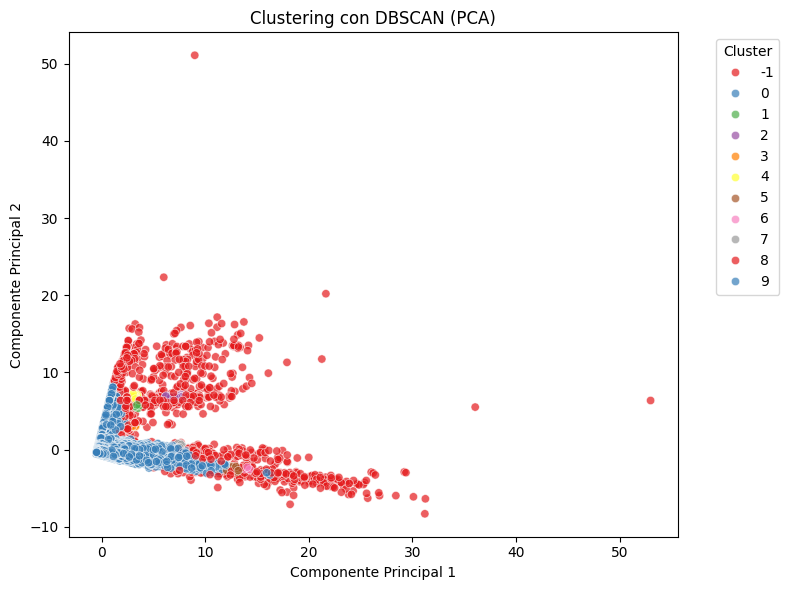

In [ ]:
# Visualización de DBSCAN en espacio PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='dbscan_cluster', palette='Set1',
    data=df_scaled, alpha=0.7
)
plt.title("Clustering con DBSCAN (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Filtramos puntos que no fueron etiquetados como ruido (-1)
mask_no_noise = df_scaled['dbscan_cluster'] != -1
X_no_noise = X_scaled[mask_no_noise]
labels_no_noise = df_scaled['dbscan_cluster'][mask_no_noise]

# Calculamos Silhouette Score si hay al menos 2 clusters
if len(np.unique(labels_no_noise)) > 1:
    score_dbscan = silhouette_score(X_no_noise, labels_no_noise)
    print(f"Silhouette Score DBSCAN (sin ruido): {score_dbscan:.3f}")
else:
    print("No se puede calcular Silhouette Score: solo se encontró un cluster (o todos son ruido).")

Silhouette Score DBSCAN (sin ruido): 0.744


## Comparación de resultados

Según la estructura del dataset, uno u otro puede ser más adecuado. K-Means es útil cuando los clusters son esféricos y bien definidos. DBSCAN se adapta mejor a formas irregulares y dispersas.

K-Means podría ser más útil en este caso para clasificar regiones o cultivos en grupos con diferente escala y eficiencia, mientras que el DBscan se puede usar como herramienta secundaria para detectar y excluir outliers antes de aplicar otros modelos.

#Conclusiones

Aunque se exploraron modelos no supervisados como KMeans y DBSCAN para identificar patrones ocultos o agrupar observaciones similares, los resultados mostraron limitaciones:

- KMeans forzó la segmentación sin una separación clara de comportamientos productivos.

- DBSCAN detectó 10 clusters.

No se encontraron agrupamientos coherentes ni interpretables. Esto sugiere que la estructura del dataset no presenta patrones de segmentación natural que aporten valor complementario al modelo supervisado desarrollado previamente.

Dado que el objetivo principal del análisis es predecir el rendimiento agrícola a partir de variables explicativas conocidas, el enfoque más adecuado es un modelo supervisado de regresión, que permite cuantificar relaciones, evaluar desempeño y generalizar sobre nuevas observaciones.

#### Dado que el modelo no estaría arrojando una conclusión significa utilzando el dataset completo, se van a utilizar los 3 cultivos con mayor produccion

In [ ]:
# Filtramos dataset considerando sólo 3 cultivos
df.drop(df[~df['cultivo'].isin(['Soja total', 'Maíz', 'Trigo total'])].index, inplace=True)

In [ ]:
df['cultivo'].unique()

array(['Maíz', 'Soja total', 'Trigo total'], dtype=object)

In [ ]:
df = df.dropna(subset=['produccion_ton'])

In [ ]:
# Chequeo de filas con valores cero o NaN
df[df.isna().any(axis=1)]

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
153754,Trigo total,0,0.0,0.0,0.0,NEA,NaN,2022
153796,Trigo total,0,0.0,0.0,0.0,NOA,NaN,2022
153798,Trigo total,0,0.0,0.0,0.0,NOA,NaN,2022


In [ ]:
#Se elimina la región Patagonia
df.drop(df[df['region'] == 'Patagonia'].index, inplace=True)

/tmp/ipython-input-80-4042427212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['region'] == 'Patagonia'].index, inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Definimos las variables finales para clustering
features2 = ['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha']

# Seleccionamos solo esas columnas y eliminamos filas con nulos
df_cluster2 = df[features2].dropna().copy()

# Escalamos los datos
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(df_cluster2)

# Guardamos en un DataFrame para facilitar análisis posterior
df_scaled2 = pd.DataFrame(X_scaled2, columns=features2)

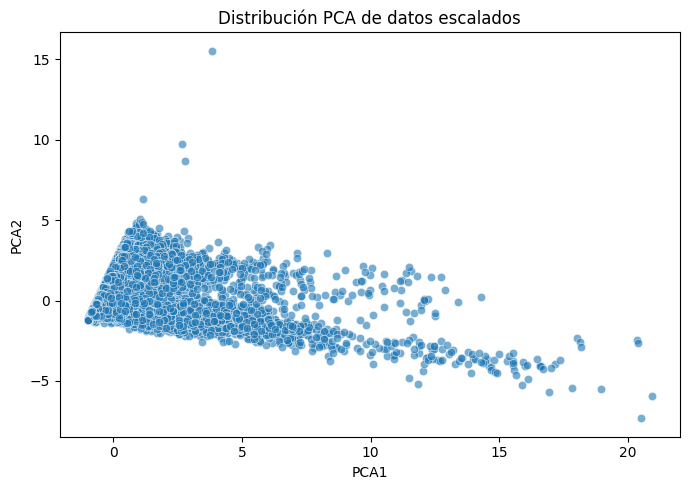

In [ ]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad para visualizar en 2D
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled2)

# Guardamos en el DataFrame
df_scaled2['PCA1'] = X_pca2[:, 0]
df_scaled2['PCA2'] = X_pca2[:, 1]

# Visualización simple
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', data=df_scaled2, alpha=0.6)
plt.title("Distribución PCA de datos escalados")
plt.tight_layout()
plt.show()

In [ ]:
# Mostrar las cargas (loadings) de cada variable en los componentes
features2 = ['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha'] # Updated features list
cargas = pd.DataFrame(
    pca2.components_,
    columns=features2,
    index=['PC1', 'PC2']
).T

print(cargas)

                        PC1       PC2
sup_sembrada_ha    0.665869 -0.304184
produccion_ton     0.694808 -0.079789
rendimiento_kg/ha  0.271773  0.949266


In [ ]:
from sklearn.decomposition import PCA

# Varianza explicada por cada componente
explained_var2 = pca2.explained_variance_ratio_

for i, var in enumerate(explained_var2):
    print(f"PC{i+1} explica el {var*100:.2f}% de la varianza")


PC1 explica el 65.46% de la varianza
PC2 explica el 31.54% de la varianza


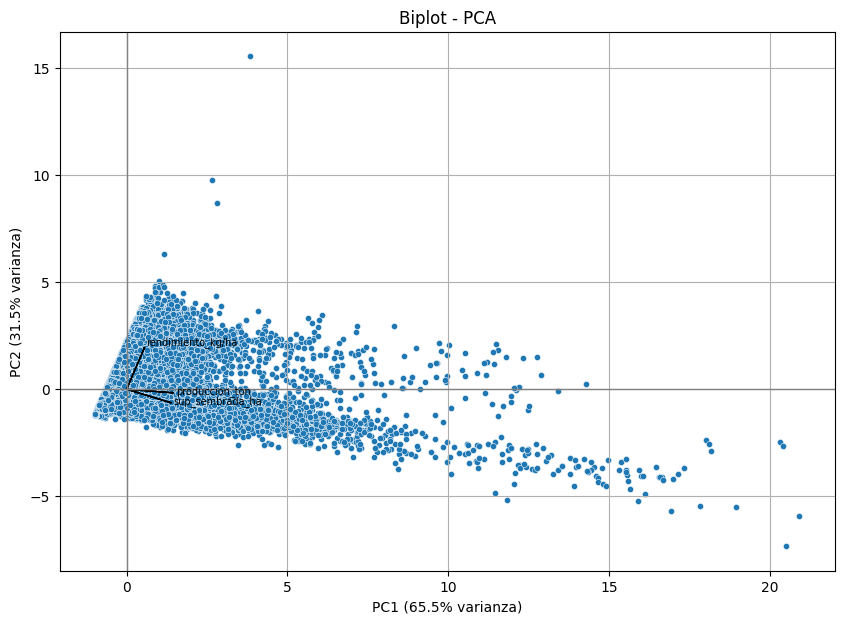

In [ ]:
# Crear biplot
plt.figure(figsize=(10, 7))

# 1. Puntos (datos proyectados)
sns.scatterplot(x=X_pca2[:, 0], y=X_pca2[:, 1], s=20)

# 2. Flechas (cargas de las variables originales)
for i, var in enumerate(['sup_sembrada_ha', 'produccion_ton', 'rendimiento_kg/ha']):
    plt.arrow(0, 0,
              pca2.components_[0, i]*2,  # escalar para que se vean bien
              pca2.components_[1, i]*2,
              color='black', head_width=0.05)
    plt.text(pca2.components_[0, i]*2.2, pca2.components_[1, i]*2.2, var, color='black', fontsize=7)

# Etiquetas y ejes
plt.xlabel(f'PC1 ({explained_var2[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({explained_var2[1]*100:.1f}% varianza)')
plt.title('Biplot - PCA')
plt.grid(True)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.show()

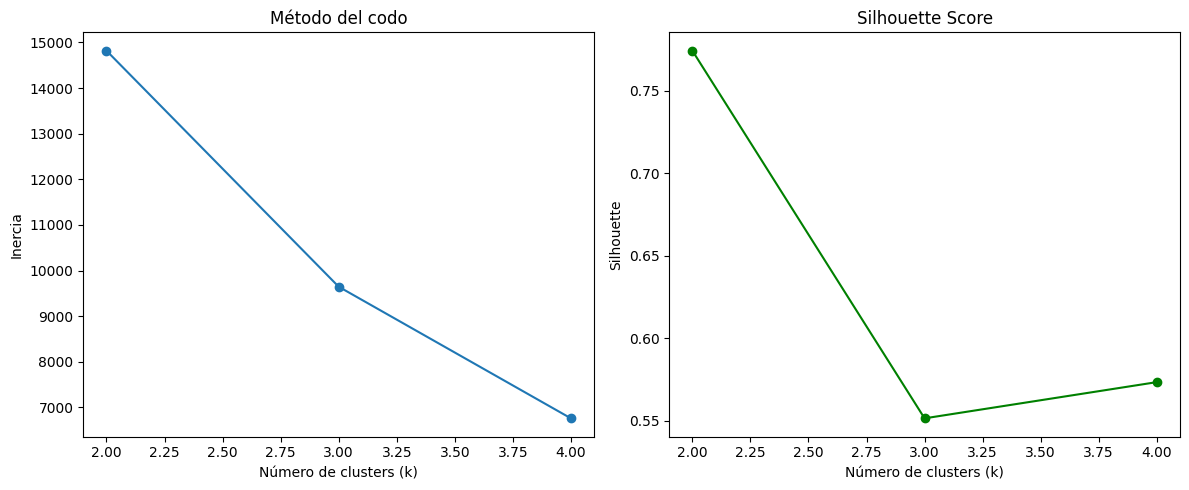

In [ ]:
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Muestreo del 20%
X_sample2 = resample(X_scaled2, n_samples=int(0.2 * len(X_scaled2)), random_state=42)

inertia2 = []
silhouette2 = []
K_range2 = range(2, 5)  # más chico

for k in K_range2:
    kmeans2 = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans2.fit(X_sample2)
    inertia2.append(kmeans2.inertia_)
    silhouette2.append(silhouette_score(X_sample2, kmeans2.labels_))

# Gráficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range2, inertia2, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")

plt.subplot(1, 2, 2)
plt.plot(K_range2, silhouette2, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()

In [ ]:
# Entrenamos el modelo KMeans con k=3
k_opt2 = 3
kmeans2 = KMeans(n_clusters=k_opt2, random_state=42)
df_scaled2['cluster'] = kmeans2.fit_predict(X_scaled2)

# Vemos distribución de clusters
df_scaled2['cluster'].value_counts().sort_index()

,count
cluster,
0,32012
1,1452
2,7043


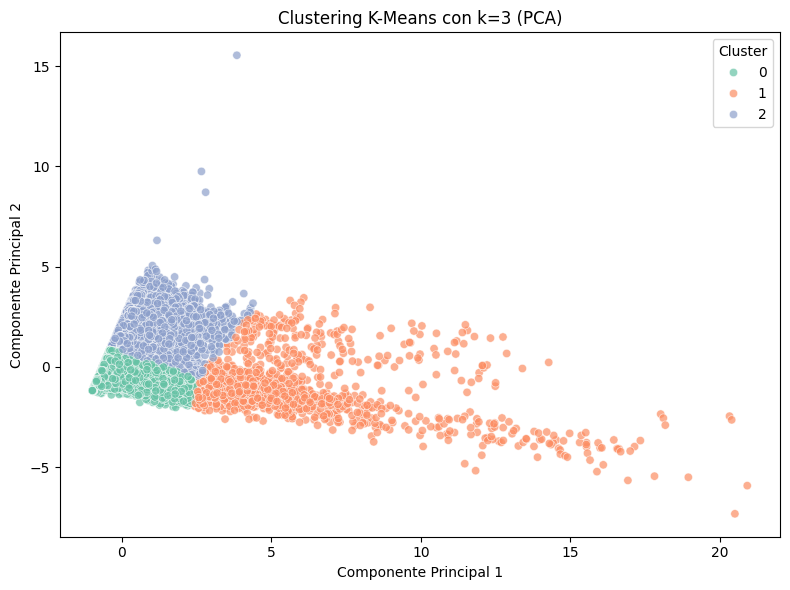

In [ ]:
# Visualización de los clusters en espacio PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='cluster', palette='Set2',
    data=df_scaled2, alpha=0.7
)
plt.title(f"Clustering K-Means con k={k_opt2} (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

La aplicación de los modelos para los 3 cultivos con mayor producción tuvo un resultado similar al anterior en donde se utilizaron todos los cultivos, por lo que se respalda la conclusión descripta anteriormente.